In [238]:
import pandas as pd
import numpy as np

import copy

import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso, LassoCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeRegressor

from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from sklearn.tree import export_graphviz 
from sklearn import tree




In [70]:
%matplotlib inline

In [15]:
data = pd.read_csv('housing.csv', sep=',')

In [17]:
data = pd.get_dummies(data, columns=['ocean_proximity'])

In [18]:
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,0,0,0,1,0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,0,0,0,1,0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,0,0,0,1,0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,0,0,0,1,0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,0,0,0,1,0


# Data Set Analysis


In [19]:
data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909,0.442636,0.317393,0.000242,0.110950,0.128779
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874,0.496710,0.465473,0.015563,0.314077,0.334963
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Distribution of Target Values

<AxesSubplot:>

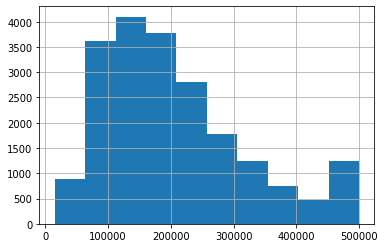

In [20]:
data['median_house_value'].hist()

Conclusions:
1) Distribution is not normal
2) About 12,000 houses are priced at 500000

## Distribution of Features

### Heat map

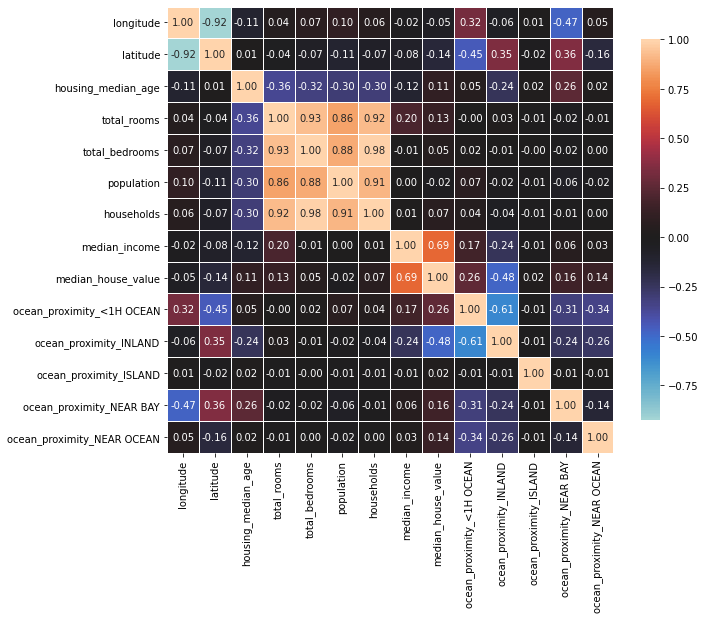

In [22]:
def correlation_heatmap(train, method):
    correlations = train.corr(method=method)

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
    plt.show();
    
correlation_heatmap(data, 'pearson')


Conclusions:
1) There is a reasonable correlation between <b>median_income</b> and <b>median_house_value</b>. 
2) Strong <b>negative</b> correlation with <b>inland</b>
3) A <b>slight positive</b> correlation with <b>1H from ocean</b>.
4) A block of correlated features: total rooms, bedrooms, population and households (not good).
5) Relationship between coordinates and ocean proximity looks complicated, needs closer examination.


### Coordinates and Ocean Proximity

In [28]:
data_original = pd.read_csv('housing.csv', sep=',')
locations = []
for location in data_original['ocean_proximity']:
    if location == 'NEAR BAY':
        locations.append('NEAR BAY')
    elif location == '<1H OCEAN':
        locations.append('<1H OCEAN')
    elif location == 'INLAND':
        locations.append('INLAND')
    elif location == 'NEAR OCEAN':
        locations.append('NEAR OCEAN')
    elif location == 'ISLAND':
        locations.append('ISLAND')
# Will only use six variables for plotting pairs
reduced_data = data_original[['latitude', 'longitude', 'housing_median_age', 'total_rooms', 'population', 'households', 'median_income', 'median_house_value']]

reduced_data['location'] = locations

/var/folders/ms/fjxdrzh149ldr7k8wp4kld080000gn/T/ipykernel_16440/4056370919.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_data['location'] = locations


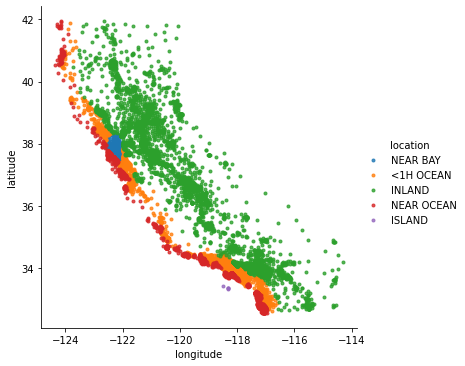

In [33]:
sns.lmplot(data = reduced_data, x ='longitude', y = 'latitude', markers = ".", fit_reg=False, hue = 'location')

In [55]:
def plot_price_on_map(data):
    plt.figure()
    cmap = LinearSegmentedColormap.from_list(name="name", colors = ['green', 'orange', 'purple'])
    f, ax = plt.subplots()
    points = ax.scatter(data['longitude'], data['latitude'], c=data['median_house_value'], s=10, cmap = cmap)

    f.colorbar(points)

<Figure size 432x288 with 0 Axes>

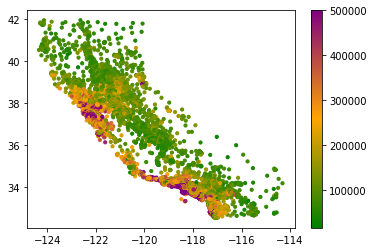

In [73]:
plot_price_on_map(reduced_data)

In [60]:
inland = reduced_data.loc[reduced_data['location'] == 'INLAND']
shore = reduced_data.loc[reduced_data['location'] == 'NEAR OCEAN']
suburbs = reduced_data.loc[reduced_data['location'] == '<1H OCEAN']
bay = reduced_data.loc[reduced_data['location'] == 'NEAR BAY']

<Figure size 432x288 with 0 Axes>

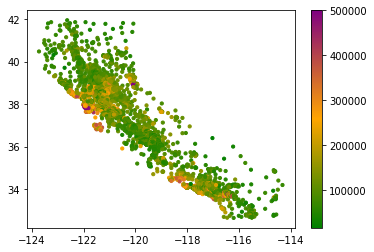

In [72]:
plot_price_on_map(inland)



<Figure size 432x288 with 0 Axes>

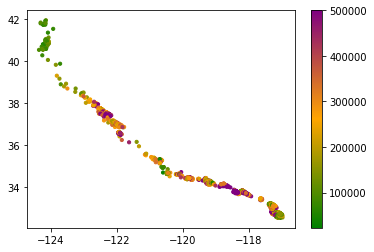

In [58]:
plot_price_on_map(shore)

<Figure size 432x288 with 0 Axes>

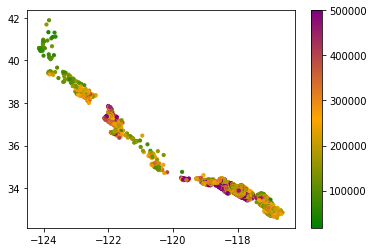

In [71]:
plot_price_on_map(suburbs)

<Figure size 432x288 with 0 Axes>

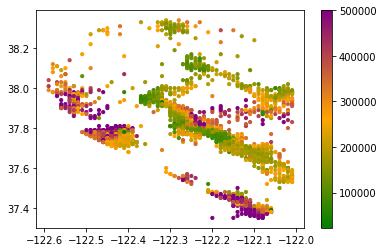

In [61]:
plot_price_on_map(bay)

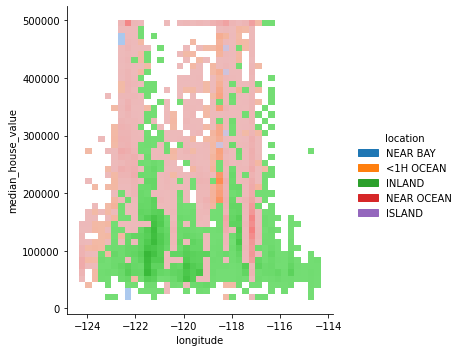

In [95]:
sns.displot(reduced_data, x="longitude", y="median_house_value", hue="location")

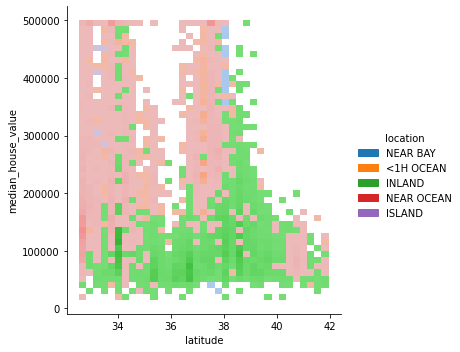

In [96]:
sns.displot(reduced_data, x="latitude", y="median_house_value", hue="location")

#### Generate new features

In [110]:
san_fran = [-122.4, 37.8]
lala_land = [-118.25, 34.0]
# r = sqrt[x^2 + y^2]
data['distance_to_sf'] = np.sqrt((data['longitude'] - san_fran[0])**2 + (data['latitude'] - san_fran[1])**2) 
data['distance_to_la'] = np.sqrt((data['longitude'] - lala_land[0])**2 + (data['latitude'] - lala_land[1])**2) 

data['distance_from_city'] = data[['distance_to_sf','distance_to_la']].min(axis=1)

In [111]:
data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN,distance_to_sf,distance_to_la,distance_from_city
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909,0.442636,0.317393,0.000242,0.110950,0.128779,3.875250,2.656736,0.897912
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874,0.496710,0.465473,0.015563,0.314077,0.334963,2.504027,2.433649,0.839059
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.182582,0.319022,0.220227
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.269848,1.671706,0.580086
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000,1.000000,1.000000,0.000000,0.000000,0.000000,5.846655,5.236993,1.424360
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000,1.000000,1.000000,1.000000,1.000000,1.000000,9.307121,9.902934,4.615463


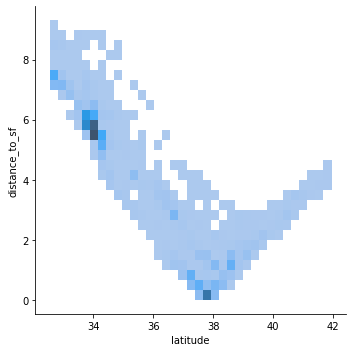

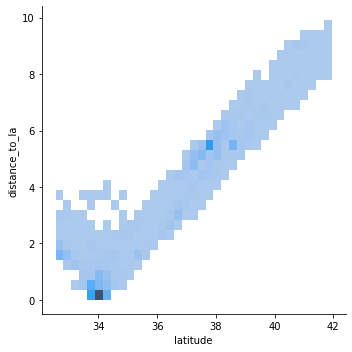

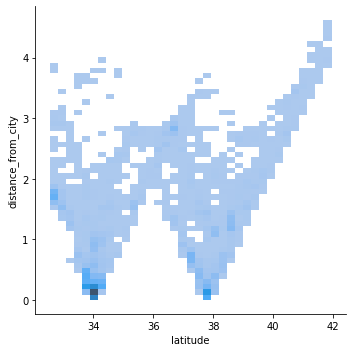

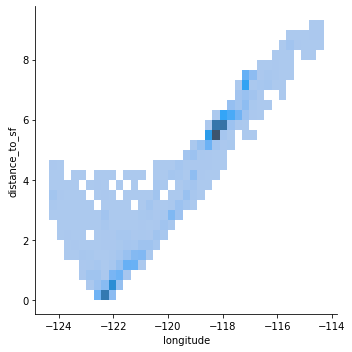

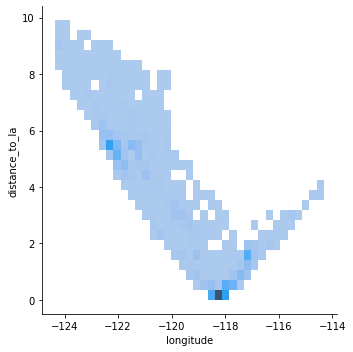

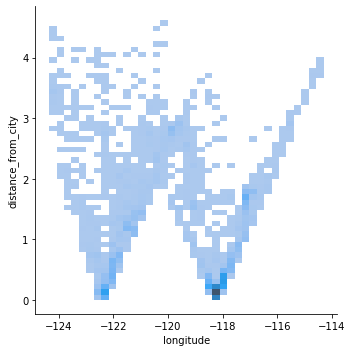

In [112]:
#sanity check
sns.displot(data, x="latitude", y="distance_to_sf")
sns.displot(data, x="latitude", y="distance_to_la")
sns.displot(data, x="latitude", y = "distance_from_city")
sns.displot(data, x="longitude", y="distance_to_sf")
sns.displot(data, x="longitude", y="distance_to_la")
sns.displot(data, x="longitude", y = "distance_from_city")

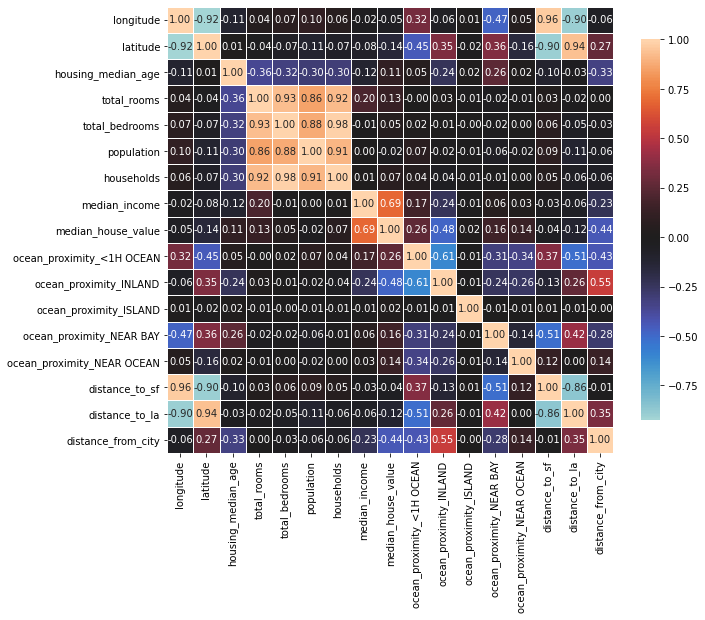

In [113]:
#revisiting the heat map
correlation_heatmap(data, 'pearson')

In [116]:
reduced_data = data_original[['housing_median_age', 'total_rooms', 'population', 'households', 'median_income', 'median_house_value']]

reduced_data['location'] = locations

/var/folders/ms/fjxdrzh149ldr7k8wp4kld080000gn/T/ipykernel_16440/885147540.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_data['location'] = locations


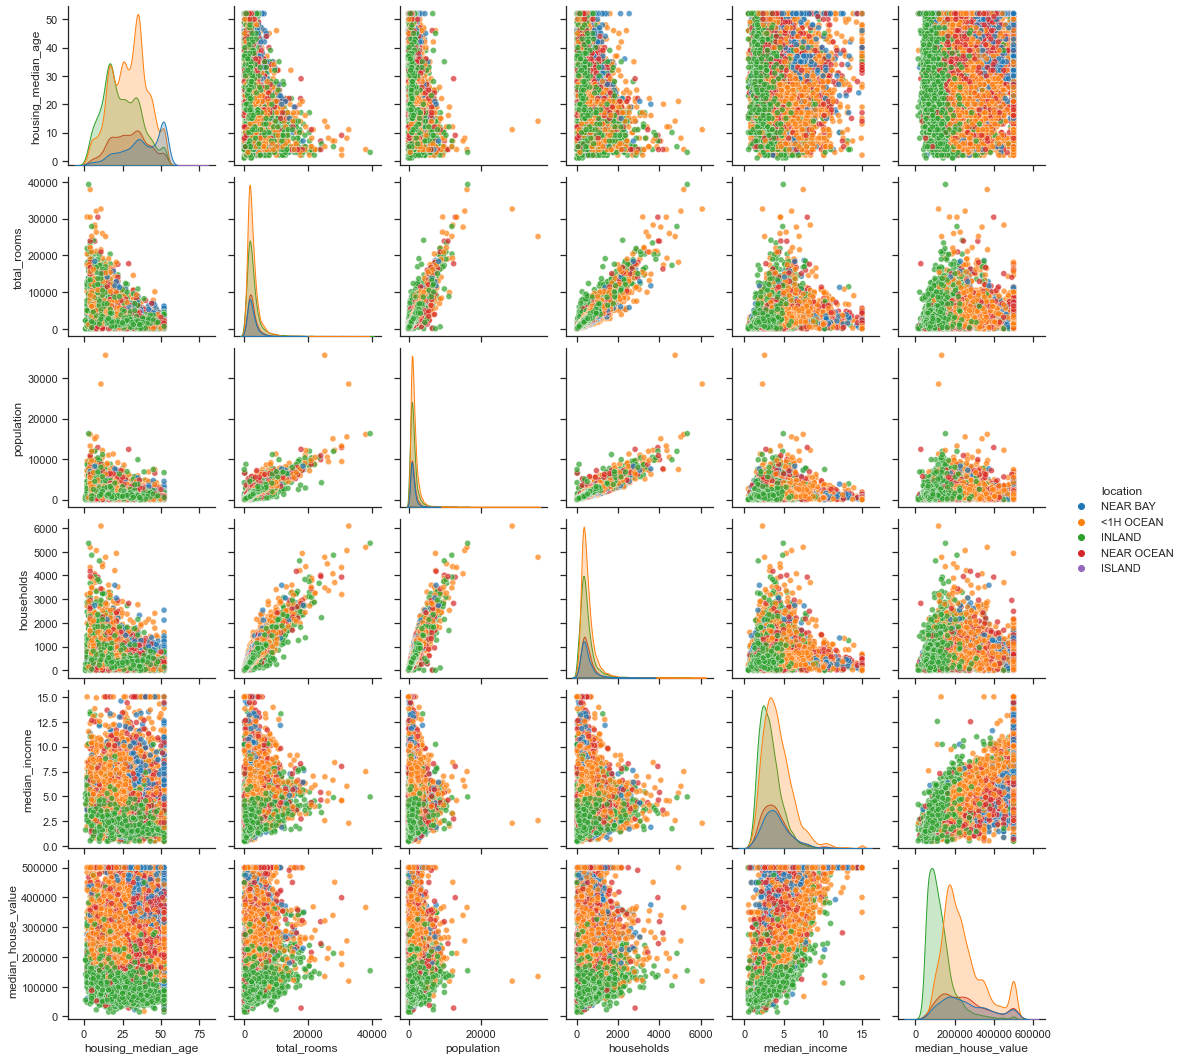

In [117]:
# Use seaborn for pair plots to see if we need to keep the ocean proximity

sns.set(style="ticks", color_codes=True);
# Create a custom color palete
palette = sns.color_palette("tab10",5)
# Make the pair plot with a some aesthetic changes
sns.pairplot(reduced_data, hue = 'location', diag_kind = 'kde', palette= palette, plot_kws=dict(alpha = 0.7),
                   diag_kws=dict(shade=True))

# Linear Model - Establishing a Base Line

In [118]:
X = data.drop(['median_house_value'], axis = 1).to_numpy()

In [120]:
y = data['median_house_value'].to_numpy()

In [152]:
#split into train and test sets


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



## Hypothesis #1: rich people live in more expensive houses
Simple Linear Regression between median income and median house value

In [123]:
X_train_lin = X_train[:,7].reshape(-1,1)
X_test_lin = X_test[:,7].reshape(-1,1)

In [125]:
model_lin_reg = LinearRegression(copy_X = True)
model_lin_reg.fit(X_train_lin, y_train)


LinearRegression()

In [128]:
def evaluate(model, test_features, test_true):
    predictions = model.predict(test_features)
    mae = mean_absolute_error(test_true, predictions)
    mse = mean_squared_error(test_true, predictions)
    rmse = np.sqrt(mse)
    print('Model Performance')
    print('MAE = {:0.2f}'.format(mae))
    print('RMSE = {:0.2f}'.format(rmse))
    plt.plot(test_true, predictions,"ro")
    return [mae, rmse]

Model Performance
MAE = 62990.87
RMSE = 84209.01


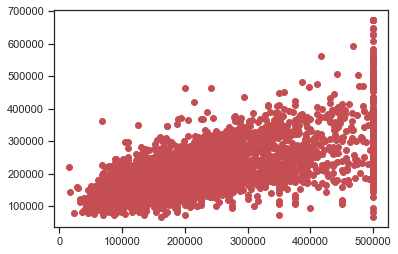

In [132]:
reg_lin_performance = evaluate(model_lin_reg, X_test_lin, y_test)

In [134]:
models_summary = {}
models_summary['linear'] = reg_lin_performance

## Hypothesis 2: Rich people also like to live near cities and ocean

For multivariate regression, the features have to be on the same scale to avoid bias.
In this case, I'm using <b>MinMaxScaler</b> and not <b>StandardScaler</b> because we already saw that our data doesn't fit a normal distirbution

In [137]:
X_train_lin2 = X_train[:,[7, 9, 15]]
X_test_lin2 = X_test[:,[7, 9, 15]]

norm = MinMaxScaler().fit(X_train_lin2)

X_train_lin2_norm = norm.transform(X_train_lin2)

X_test_lin2_norm = norm.transform(X_test_lin2)

In [138]:
model_lin_reg2 = LinearRegression().fit(X_train_lin2_norm, y_train)

Model Performance
MAE = 53166.61
RMSE = 73663.93


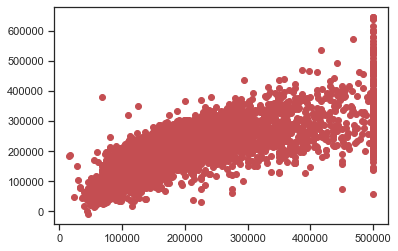

In [139]:
reg_lin2_performance = evaluate(model_lin_reg2, X_test_lin2_norm, y_test)

In [140]:
models_summary['linear_multi'] = reg_lin2_performance

## LASSO

In [173]:
# define imputer to fill in the NaN values in total_bedrooms
imputer = KNNImputer(n_neighbors = 20)
imputer.fit(X_train)
X_train_filled = imputer.transform(X_train)

#print(test_imputer_filled)


In [175]:
test_imputer = copy.copy(X_train[10,:])

test_imputer[4] = 'NaN'
test_imputer[7] = 'NaN'
test_imputer_filled = imputer.transform(test_imputer.reshape(1,-1))

print("Original values", X_train[10,4], X_train[10,7])
print("Imputed values", test_imputer_filled[0,4], test_imputer_filled[0,7])



Original values 197.0 4.2167
Imputed values 199.9 3.152780000000001


In [177]:
# scale the data:
norm = MinMaxScaler().fit(X_train_filled)
X_train_filled_norm = norm.transform(X_train_filled)
X_test_filled_norm = norm.transform(imputer.transform(X_test))

In [180]:
model_lasso = LassoCV(max_iter = 10000)
model_lasso.fit(X_train_filled_norm, y_train)
columns = data.drop(['median_house_value'], axis = 1).columns
print("Best alpha using built-in LassoCV: %f" % model_lasso.alpha_)
print("Best score using built-in LassoCV: %f" %model_lasso.score(X_train_filled_norm,y_train))
coef = pd.Series(model_lasso.coef_, index = columns)

Best alpha using built-in LassoCV: 25.967487
Best score using built-in LassoCV: 0.659316


In [181]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 14 variables and eliminated the other 2 variables


Text(0.5, 1.0, 'Feature importance using Lasso Model')

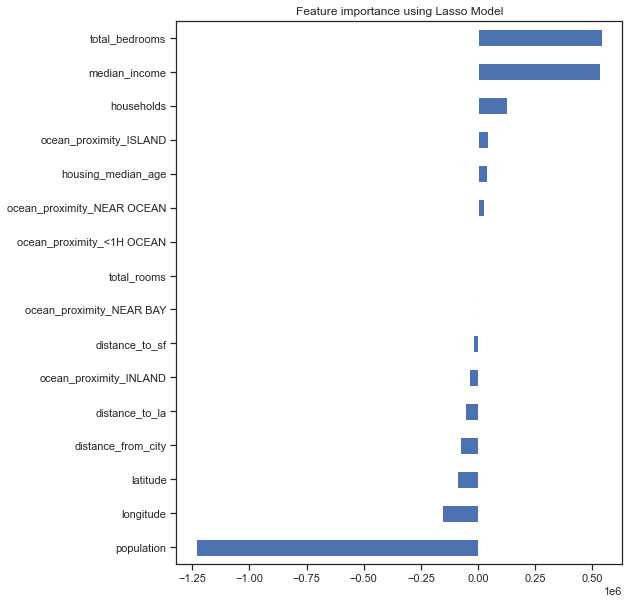

In [184]:
imp_coef = coef.sort_values()

plt.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

Model Performance
MAE = 49160.00
RMSE = 68330.71


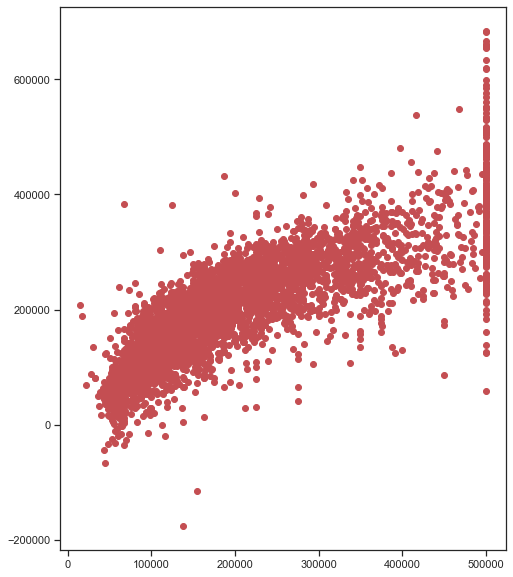

In [186]:
reg_lasso_performance = evaluate(model_lasso, X_test_filled_norm, y_test)

In [187]:
models_summary['linear_lasso'] = reg_lasso_performance

# Decision Tree Models

### Simple Tree

Model Performance
MAE = 55454.49
RMSE = 76813.09


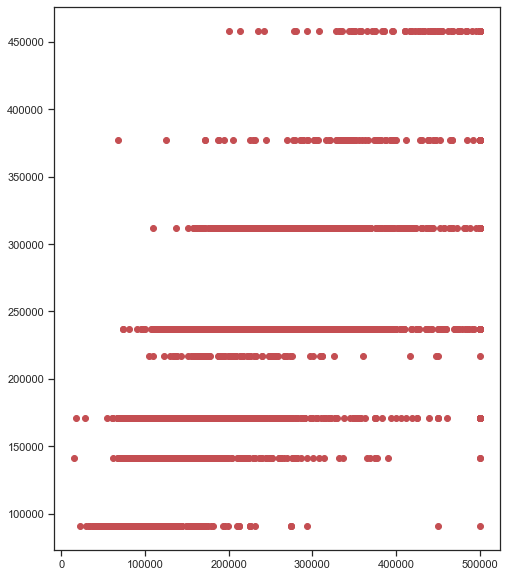

In [194]:
#this is is underfit but we can visualize it
model_tree = DecisionTreeRegressor(max_depth=3, min_samples_split = 5)
model_tree.fit(X_train_filled, y_train)
reg_tree_performance = evaluate(model_tree, X_test_filled, y_test)

In [197]:
#let's plot the tree
export_graphviz(model_tree, out_file ='tree.dot',
               feature_names =columns)

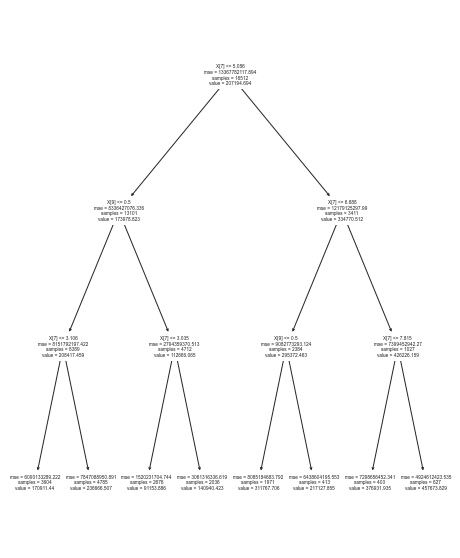

In [200]:
tree.plot_tree(model_tree);

Model Performance
MAE = 32630.84
RMSE = 48207.31
Model Performance
MAE = 38715.26
RMSE = 58953.62


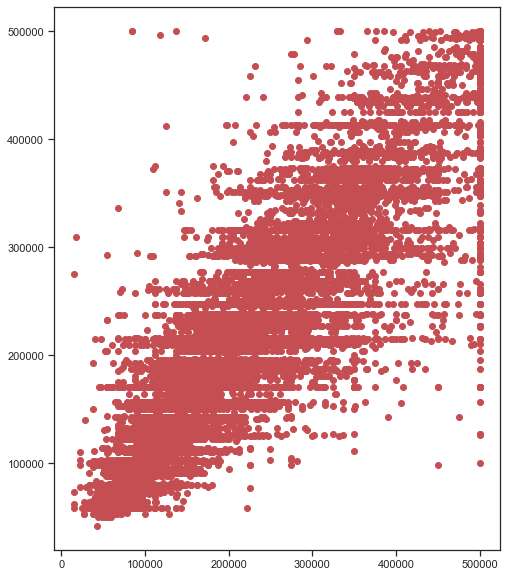

In [207]:
#this one looks better
model_tree2 = DecisionTreeRegressor(max_depth=10, min_samples_split = 10)
model_tree2.fit(X_train_filled, y_train)
evaluate(model_tree2, X_train_filled, y_train)
reg_tree_performance = evaluate(model_tree2, X_test_filled, y_test)

In [208]:
models_summary['one_tree'] = reg_tree_performance

Model Performance
MAE = 0.00
RMSE = 0.00
Model Performance
MAE = 40331.39
RMSE = 64072.41


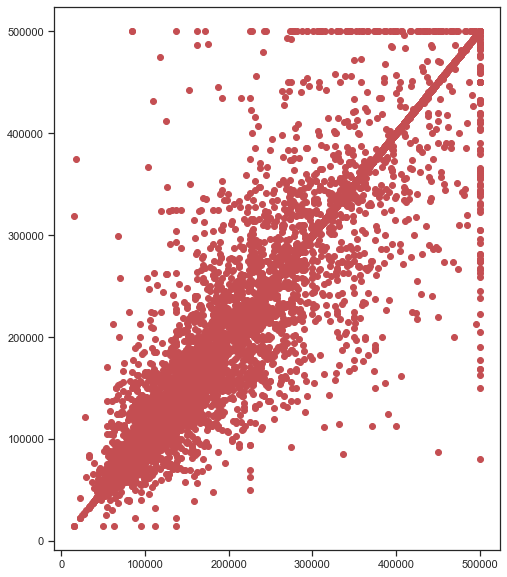

In [206]:
#this is overfit
model_tree3 = DecisionTreeRegressor()
model_tree3.fit(X_train_filled, y_train)
evaluate(model_tree3, X_train_filled, y_train)
evaluate(model_tree3, X_test_filled, y_test)

## Random Forest

In [210]:

model_forest = RandomForestRegressor()
scaler = MinMaxScaler()
imputer = KNNImputer(n_neighbors= 20)

#create a pipeline to fit missing values on train and apply on validation


pipeline = Pipeline(steps=[ ('i', imputer), ('s', scaler), ('m', model_forest)])

# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)



## evaluate model
scores = cross_val_score(pipeline, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = np.absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))



#pipeline.fit(X_train, y_train)

Mean MAE: 30471.423 (769.143)


In [211]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('i', KNNImputer(n_neighbors=20)), ('s', MinMaxScaler()),
                ('m', RandomForestRegressor())])

Model Performance
MAE = 30073.14
RMSE = 47325.07


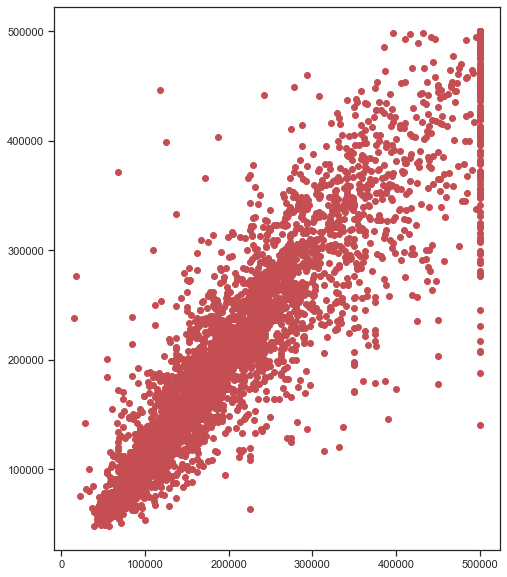

In [212]:
reg_forset_performance = evaluate(pipeline, X_test, y_test)

### What did the forest learn?

In [227]:
# Get numerical feature importances
importances = list(model_forest.feature_importances_)
feature_list = data.drop(['median_house_value'], axis = 1).columns
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
#[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]
for pair in feature_importances:
    #print(pair)
    print('Variables: {} Importance: {}'.format(*pair))

Variables: median_income Importance: 0.48
Variables: ocean_proximity_INLAND Importance: 0.14
Variables: latitude Importance: 0.06
Variables: distance_to_sf Importance: 0.06
Variables: longitude Importance: 0.05
Variables: distance_from_city Importance: 0.05
Variables: housing_median_age Importance: 0.03
Variables: distance_to_la Importance: 0.03
Variables: total_rooms Importance: 0.02
Variables: total_bedrooms Importance: 0.02
Variables: population Importance: 0.02
Variables: households Importance: 0.01
Variables: ocean_proximity_NEAR OCEAN Importance: 0.01
Variables: ocean_proximity_<1H OCEAN Importance: 0.0
Variables: ocean_proximity_ISLAND Importance: 0.0
Variables: ocean_proximity_NEAR BAY Importance: 0.0


### Hyper Parameter Optimization

In [228]:
print('Parameters currently in use:\n')
print(model_forest.get_params())

Parameters currently in use:

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [229]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 100)]
# Number of features to consider at every split
max_features = ['auto']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [5, 10, 15]
# Minimum number of samples required at each leaf node
min_samples_leaf = [5, 8, 10]
# Method of selecting samples for training each tree
bootstrap = [True]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 218, 236, 254, 272, 290, 309, 327, 345, 363, 381, 400, 418, 436, 454, 472, 490, 509, 527, 545, 563, 581, 600, 618, 636, 654, 672, 690, 709, 727, 745, 763, 781, 800, 818, 836, 854, 872, 890, 909, 927, 945, 963, 981, 1000, 1018, 1036, 1054, 1072, 1090, 1109, 1127, 1145, 1163, 1181, 1200, 1218, 1236, 1254, 1272, 1290, 1309, 1327, 1345, 1363, 1381, 1400, 1418, 1436, 1454, 1472, 1490, 1509, 1527, 1545, 1563, 1581, 1600, 1618, 1636, 1654, 1672, 1690, 1709, 1727, 1745, 1763, 1781, 1800, 1818, 1836, 1854, 1872, 1890, 1909, 1927, 1945, 1963, 1981, 2000], 'max_features': ['auto'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [5, 10, 15], 'min_samples_leaf': [5, 8, 10], 'bootstrap': [True]}


In [230]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf= RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train_filled, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto'],
                                        'min_samples_leaf': [5, 8, 10],
                                        'min_samples_split': [5, 10, 15],
                                        'n_estimators': [200, 218, 236, 254,
                                                         272, 290, 309, 327,
                                                         345, 363, 381, 400,
                                                         418, 436, 454, 472,
                                                         490, 509, 527, 545,
                         

[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=15, n_estimators=1290; total time= 1.5min
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=15, n_estimators=672; total time=  53.4s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=1618; total time= 2.4min
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=5, min_samples_split=15, n_estimators=1727; total time= 2.5min
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1254; total time= 1.7min
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=1981; total time= 3.0min
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=15, n_estimators=1836; total time= 2.9min
[CV] END bootstrap=True, max_de

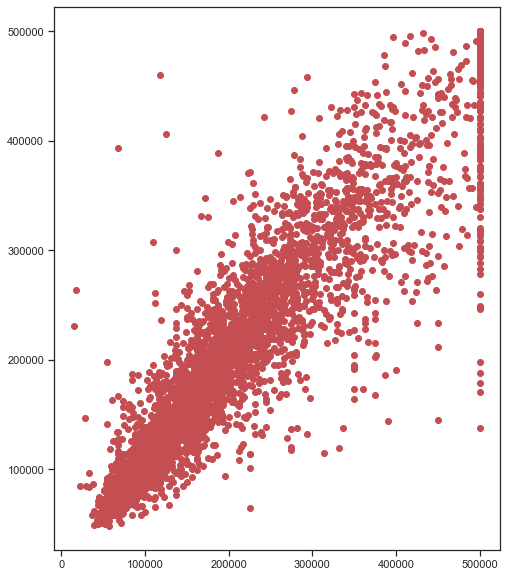

[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=1854; total time= 2.4min
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1745; total time= 2.3min
[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=563; total time=  51.0s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=8, min_samples_split=15, n_estimators=1400; total time= 2.0min
[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=1090; total time= 1.5min
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=1818; total time= 2.2min
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=8, min_samples_split=5, n_estimators=1418; total time= 2.0min
[CV] END bootstrap=True, max_depth

In [231]:
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test_filled, y_test)

In [232]:
rf_random.best_params_

{'n_estimators': 2000,
 'min_samples_split': 5,
 'min_samples_leaf': 5,
 'max_features': 'auto',
 'max_depth': 30,
 'bootstrap': True}

[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=1854; total time= 2.4min
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1745; total time= 2.3min
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=5, min_samples_split=15, n_estimators=1727; total time= 2.5min
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1254; total time= 1.7min
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=1981; total time= 3.0min
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=10, min_samples_split=15, n_estimators=1218; total time= 1.7min
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=1200; total time= 1.7min
[CV] END bootstrap=True, max

In [233]:
import joblib
joblib.dump(pipeline, "./pipeline_rf_best.joblib")

['./pipeline_rf_best.joblib']

# Neural Networks

Split manually the train set further into test and validation

In [263]:
xt, xv, yt, yv = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [264]:
# impute and scale
scaler = MinMaxScaler()
imputer = KNNImputer(n_neighbors= 20)
xt = imputer.fit_transform(xt)
xv =  imputer.transform(xv)
xt = scaler.fit_transform(xt)
xv = scaler.transform(xv)

xtest = scaler.transform(imputer.transform(X_test))


In [245]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import save_model, load_model
from keras.backend import clear_session

In [265]:
#Let's try everyone's favorite deeplearning

clear_session()
model = Sequential()

model.add(Dense(32,activation='relu'))

model.add(Dropout(0.25))
model.add(Dense(16,activation='relu'))

model.add(Dropout(0.25))

model.add(Dense(8,activation='relu'))

model.add(Dropout(0.25))

model.add(Dense(1))

model.compile(optimizer='adam', loss='mae')



In [247]:
from tensorflow.keras.callbacks import EarlyStopping

In [259]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights = True)

In [266]:
model.compile('adam',loss='mae',  metrics=['mae'])

#model.summary()

In [271]:
model.fit(x=xt,y=yt,
          validation_data=(xv,yv),
          batch_size = 128, epochs = 100, callbacks = [early_stop])

Epoch 1/100
97/97 [==============================] - 0s 1ms/step - loss: 68646.4766 - mae: 68646.4766 - val_loss: 49009.6797 - val_mae: 49009.6797
Epoch 2/100
97/97 [==============================] - 0s 998us/step - loss: 68881.3047 - mae: 68881.3047 - val_loss: 49011.6719 - val_mae: 49011.6719
Epoch 3/100
97/97 [==============================] - 0s 1ms/step - loss: 69280.7422 - mae: 69280.7422 - val_loss: 49246.4375 - val_mae: 49246.4375
Epoch 4/100
97/97 [==============================] - 0s 1ms/step - loss: 68725.5391 - mae: 68725.5391 - val_loss: 48949.2617 - val_mae: 48949.2617
Epoch 5/100
97/97 [==============================] - 0s 992us/step - loss: 68593.8516 - mae: 68593.8516 - val_loss: 48875.2148 - val_mae: 48875.2148
Epoch 6/100
97/97 [==============================] - 0s 1ms/step - loss: 69837.9453 - mae: 69837.9453 - val_loss: 49152.2266 - val_mae: 49152.2266
Epoch 7/100
97/97 [==============================] - 0s 994us/step - loss: 69982.7266 - mae: 69982.7266 - val_loss

Model Performance
MAE = 48536.62
RMSE = 74104.52


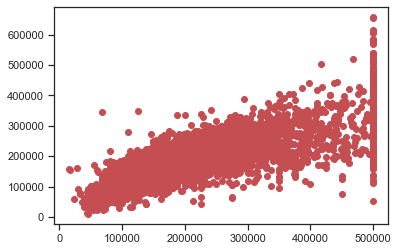

In [272]:
nn_best_performance = evaluate(model, xtest, y_test)